In [127]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, ZGate, IGate
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector

import numpy as np
from sklearn.preprocessing import normalize

import itertools

In [128]:
# Dictionary of supported code tableaus
tableau_dict = {
    "steane": [
        [XGate(),XGate(),XGate(),XGate(),IGate(),IGate(),IGate()],
        [IGate(),XGate(),XGate(),IGate(),IGate(),XGate(),XGate()],
        [XGate(),IGate(),XGate(),IGate(),XGate(),IGate(),XGate()],
        [ZGate(),ZGate(),ZGate(),ZGate(),IGate(),IGate(),IGate()],
        [IGate(),ZGate(),ZGate(),IGate(),IGate(),ZGate(),ZGate()],
        [ZGate(),IGate(),ZGate(),IGate(),ZGate(),IGate(),ZGate()],
    ],
    "five": [
        [XGate(),ZGate(),ZGate(),XGate(),IGate()],
        [IGate(),XGate(),ZGate(),ZGate(),XGate()],
        [XGate(),IGate(),XGate(),ZGate(),ZGate()],
        [ZGate(),XGate(),IGate(),XGate(),ZGate()],
    ],
}

In [129]:
# Function which generates an encoding circuit for a given tableau
def generate_encoding_circuit(tableau):
    # The number of qubits is equal to the length of any stabilizer
    n_qubits = len(tableau[0])
    sum_matrices = [np.identity(2) for _ in range(n_qubits)]

    qubit0_ops = "I"

    # Method from Gottesman's paper:
    # Step 1: Sum every combination of every number of stabilizers
    for length in range(len(tableau) + 1):
        for stabilizer_combination in itertools.combinations(tableau, length):
            for stabilizer in stabilizer_combination:
                for qubit, gate in enumerate(stabilizer):
                    sum_matrices[qubit] += np.real(gate.to_matrix())

                    if qubit == 0:
                        qubit0_ops += gate.name[0].upper()
    
    print("Our qubit 0 operation:      ", qubit0_ops)
    print("Gottesman qubit 0 operation: IXIXZXIXXXZIXIZXZXIXXIZXXZIXZXIXZ")

    # Step 2: Normalize each qubit matrix and apply the respective unitary
    encoding_circuit = QuantumCircuit(n_qubits)
    for qubit, sum_matrix in enumerate(sum_matrices):
        # @TODO - After "normalization", the matrix is not unitary
        unitary_matrix = normalize(sum_matrix, axis=1, norm="l2")
        print(unitary_matrix.dot(unitary_matrix.conj().T)) # <-- not the identity!

        unitary_operator = Operator(unitary_matrix)
        encoding_circuit.unitary(unitary_operator, qubits=[qubit])
 
    return encoding_circuit

In [130]:
encoding_circuit = generate_encoding_circuit(tableau_dict["five"])
print("Number of gates:", sum(encoding_circuit.count_ops().values()))

Our qubit 0 operation:       IXIXZXIXXXZIXIZXZXIXXIZXXZIXZXIXZ
Gottesman qubit 0 operation: IXIXZXIXXXZIXIZXZXIXXIZXXZIXZXIXZ
[[1.         0.76953376]
 [0.76953376 1.        ]]
[[1.         0.76953376]
 [0.76953376 1.        ]]
[[1.       0.516076]
 [0.516076 1.      ]]
[[1.         0.06249988]
 [0.06249988 1.        ]]
[[1.       0.516076]
 [0.516076 1.      ]]
Number of gates: 0


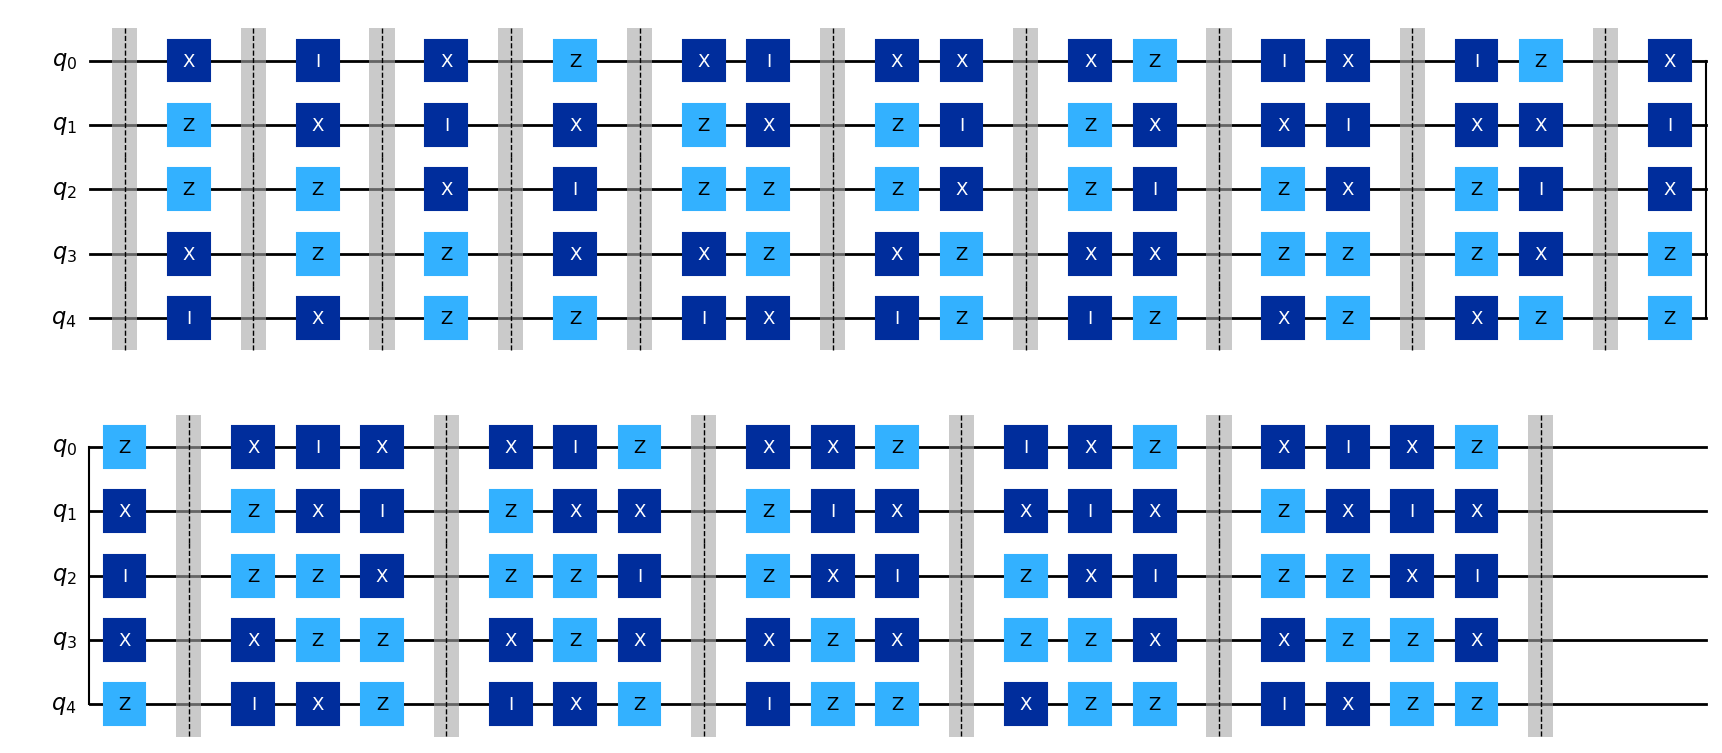

In [104]:
encoding_circuit.draw('mpl')

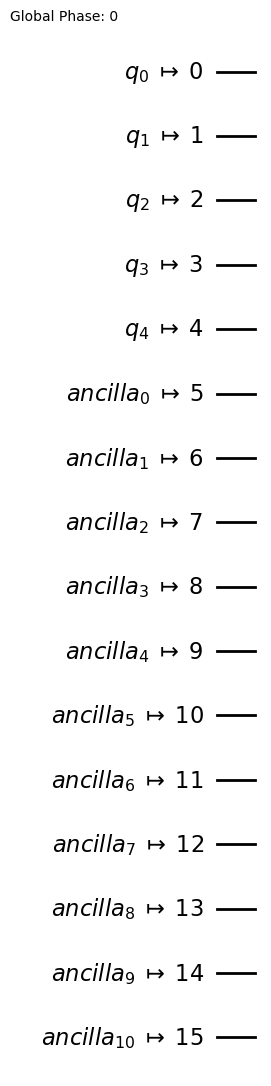

In [7]:
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(16)

transpiled_encoding_circuit = transpile(encoding_circuit, backend, optimization_level=1)
transpiled_encoding_circuit.draw('mpl')

In [8]:
# Draw the state encoded by the circuit
encoded_state = Statevector.from_instruction(encoding_circuit)
encoded_state.draw('latex')

<IPython.core.display.Latex object>